In [1]:
from dense_image_aligment import show_data, image_aligment_method, read_as_grayscale
from dense_image_aligment import save_aligment_progress, read_as_colored, show_data
import numpy as np

In [2]:
image = read_as_grayscale('../media/kanade_image.jpg')
templ = read_as_grayscale('../media/kanade.jpg')

In [3]:
method, params = image_aligment_method(key='forward_additive')
params['alpha'] = 1.0
params['max_iterations'] = 500
params['p_init'] = np.array(
    [
        [1, 0.1, 40], 
        [0.2, 1., 70.],
    ]
)

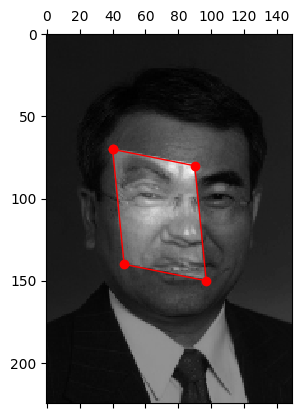

In [4]:
show_data(
    image=image, 
    template=templ, 
    mat_affine=params['p_init']
)

In [5]:
ps = method(
    image=image,
    template=templ,
    **params
)

iteration: 7, |∇p|=0.05653:   0%|          | 0/500 [00:00<?, ?it/s]

iteration: 316, |∇p|=0.00003:  63%|██████▎   | 316/500 [00:00<00:00, 367.01it/s]

Converged.


In [6]:
# save_aligment_progress(
#     f'./media/progress_example.gif',
#     image=image,
#     template=templ,
#     mat_affine_list=ps,
#     duration=100,
# )

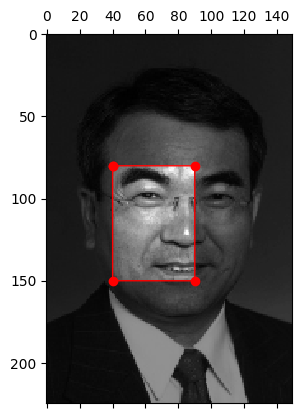

In [7]:
show_data(
    image=image, 
    template=templ, 
    mat_affine=ps[-1]
)

# Adding noise

In [8]:
from tqdm import tqdm 
import cv2 
import matplotlib.pyplot as plt 


params['alpha'] = 1.0
params['max_iterations'] = 500
params['p_init'] = np.array(
    [
        [1, 0.1, 40], 
        [0.2, 1., 70.],
    ]
)
params['verbose'] = False 



In [9]:
errors = []
n_exp = 100
sigmas = np.linspace(0, 0.95, 100)

for sigma in tqdm(sigmas):
    errors_in_exp = []
    for n_e in range(n_exp):

        image = read_as_grayscale('../media/kanade_image.jpg')
        templ = read_as_grayscale('../media/kanade.jpg')

        templ += np.random.randn(*templ.shape) * sigma
        image += np.random.randn(*image.shape) * sigma

        ps = method(
            image=image,
            template=templ,
            **params
        )

        p_inv = cv2.invertAffineTransform(ps[-1])
        
        image = read_as_grayscale('../media/kanade_image.jpg')
        templ = read_as_grayscale('../media/kanade.jpg')
        
        templ_w = cv2.warpAffine(templ, p_inv, image.shape[::-1])
        error = np.linalg.norm(image - templ_w) ** 2
        errors_in_exp.append(error)
    errors_in_exp = np.array(errors_in_exp, dtype=np.float32)
    errors.append([errors_in_exp.min(), errors_in_exp.mean(), errors_in_exp.max()])
    
errors = np.array(errors, dtype=np.float32)

100%|██████████| 100/100 [19:37<00:00, 11.77s/it]


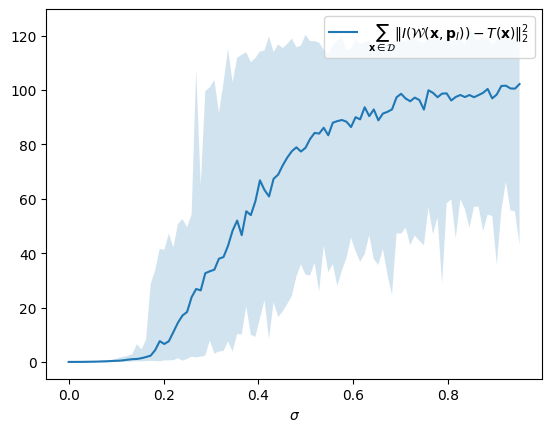

In [11]:
plt.fill_between(
    sigmas, 
    errors[:, 0],
    errors[:, 2],
    alpha = 0.2
)

plt.plot(
    sigmas, 
    errors[:, 1],
    label=r'$\sum_{\mathbf{x} \in \mathcal{D}} \|I(\mathcal{W}(\mathbf{x}, \mathbf{p}_I)) - T(\mathbf{x})\|_2^2$'
)

plt.plot
plt.xlabel(r'$\sigma$')
# plt.ylabel()
plt.legend(loc='best')
plt.show()